## Import libs and initialize working dir

https://nps01-my.sharepoint.com/personal/jimmy_lozano_nps_edu/_layouts/15/stream.aspx?id=%2Fpersonal%2Fjimmy%5Flozano%5Fnps%5Fedu%2FDocuments%2FRecordings%2FFinal%20Project%5F%20Wave%20Height%2D20240903%5F102846%2DMeeting%20Recording%2Emp4&referrer=StreamWebApp%2EWeb&referrerScenario=AddressBarCopied%2Eview%2E30ad6f1e%2D4e26%2D4b1d%2D8907%2Db3cd352f5100&ga=1

In [1]:
import pandas as pd
import os
import numpy as np

if os.getcwd()[-4:] != 'Data2023':
    os.chdir(f'{os.getcwd()}\Data2023')



## Read in buoy data 
Taken from: https://www.ndbc.noaa.gov/data/realtime2/


https://www.ndbc.noaa.gov/faq/rt_data_access.shtml

Historical data: https://www.ndbc.noaa.gov/historical_data.shtml


In [3]:
#Get list of files in data dir    
files = os.listdir()
buoy_cols = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'PTDY', 'TIDE']
combined_df = pd.DataFrame(columns=buoy_cols) #initialize empty df with column names 

#Get files that are only length 5 since buoy names are this exact amount of chars
dfs = [pd.read_csv(file, delimiter='\s+', skiprows=2, names=buoy_cols) for file in files if len(file[0:-4]) == 5]

combined_df = pd.concat(dfs, ignore_index=True) #combine all datasets of all buoys 

### Clean up data (datetime and missing values)

In [4]:
combined_df['Datetime'] = pd.to_datetime(combined_df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
combined_df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
full = combined_df
full.replace('MM', np.nan, inplace=True)
# Extract date part from datetime for grouping
full['Date'] = full['Datetime'].dt.date

In [5]:
#Get features that we care about 
features = ['WVHT','WSPD', 'WDIR', 'GST']
for f in features:
    full[f] = pd.to_numeric(full[f], errors='coerce') #change nan values to numeric
    
#Get average of features we care about to get general idea of location in question
BuoyData = full.groupby('Date').agg({
    'WVHT': 'mean',
    'WSPD': 'mean',
    'WDIR': 'mean',
    'GST': 'mean'
}).reset_index()

#Reset Date column to merge with weather data
BuoyData['Date'] = pd.to_datetime(BuoyData['Date']) 

# Same thing on weather data
Taken from: https://www.weather.gov/wrh/climate?wfo=sgx

In [9]:
#Weather data
dfs = [pd.read_csv(file, delimiter='\s+', header=0 ) for file in files if len(file[0:-4]) > 5]
combined_df = pd.concat(dfs, ignore_index=True)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
full = combined_df
full.replace('M', np.nan, inplace=True)

features = ['Avg','Dep']
for f in features:
    full[f] = pd.to_numeric(full[f], errors='coerce') #change nan values to numeric
    
    
#keep only relevant features 
WeatherData = full[['Date','Avg','Dep','Prec']]  

# Now combine weather and buoy data

In [10]:
# Merge DataFrames on the 'Date' column
Final = pd.merge(WeatherData, BuoyData, on='Date', how='inner')  

# Display the merged DataFrame
print(Final)
print('\n\n\nSummary Statistics:')
Final.describe()

          Date   Avg  Dep  Prec      WVHT       WSPD        WDIR        GST
0   2023-01-01  58.5  0.8  1.02  1.995481  92.041667  940.032051  92.335256
1   2023-01-02  56.0 -1.8  0.02  2.543236  91.788026  941.336570  91.935599
2   2023-01-03  59.0  1.2  0.34  1.508745  91.613725  932.941176  91.839608
3   2023-01-04  62.0  4.1  0.03  1.740513  91.742949  934.487179  91.992308
4   2023-01-05  59.0  1.1  0.22  1.691731  91.773077  934.794872  92.007372
..         ...   ...  ...   ...       ...        ...         ...        ...
360 2023-12-27  58.5  1.0  0.00  1.230577  91.477564  933.179487  91.569231
361 2023-12-28  58.0  0.5  0.00  1.468301  91.574359  939.791667  91.685577
362 2023-12-29  57.5 -0.1  0.00  2.565256  91.506090  938.362179  91.595192
363 2023-12-30  58.0  0.4  0.27  2.042340  91.569231  935.458333  91.689103
364 2023-12-31  57.0 -0.7  0.02  2.366603  91.612500  938.016026  91.743590

[365 rows x 8 columns]



Summary Statistics:


,Avg,Dep,WVHT,WSPD,WDIR,GST
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,63.157534,-1.577260,1.128516,91.543529,937.894168,91.656306
std,6.235795,2.683149,0.538786,0.286516,4.285305,0.302091
min,50.000000,-9.700000,0.449263,90.161742,927.538462,90.261742
25%,58.500000,-3.200000,0.801346,91.497436,934.641026,91.590064
50%,63.000000,-1.600000,0.985994,91.549359,937.929936,91.653205
75%,68.000000,0.000000,1.275000,91.611538,941.208333,91.719231
max,78.500000,6.200000,6.042432,94.141118,957.483553,94.297368


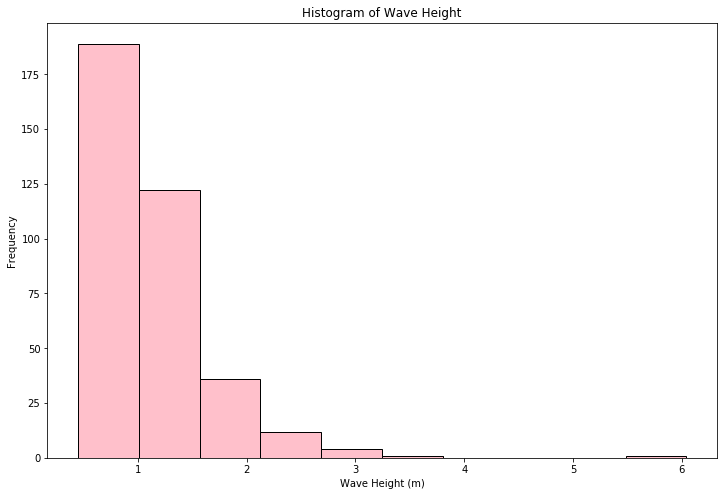

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
Final['WVHT'].plot(kind='hist', edgecolor='black', color = 'pink')

# Add titles and labels
plt.title('Histogram of Wave Height')
plt.xlabel('Wave Height (m)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

Text(16.299999999999997, 0.5, 'Wave Height (m)')

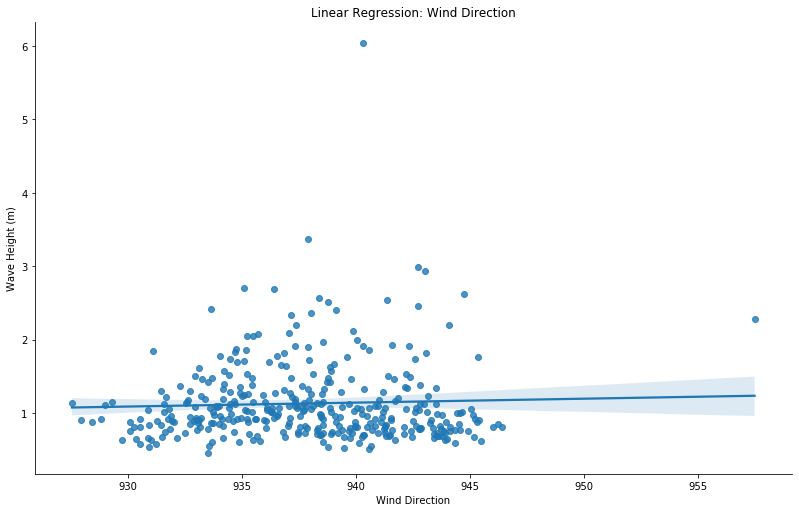

In [36]:
import seaborn as sns

sns.lmplot(x='WDIR',y='WVHT',data=Final,fit_reg=True, height = 7, aspect = 1.6) #could get rid of outliers in data cleanup process 

# Add titles and labels
plt.title('Linear Regression: Wind Direction')
plt.xlabel('Wind Direction')
plt.ylabel('Wave Height (m)')


Text(16.299999999999997, 0.5, 'Wave Height (m)')

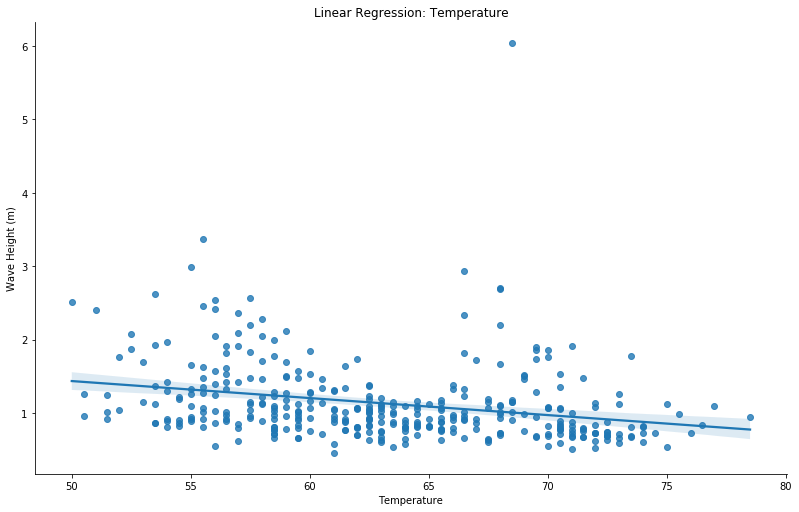

In [39]:
sns.lmplot(x='Avg',y='WVHT',data=Final,fit_reg=True, height = 7, aspect = 1.6) #could get rid of outliers in data cleanup process 

# Add titles and labels
plt.title('Linear Regression: Temperature')
plt.xlabel('Temperature')
plt.ylabel('Wave Height (m)')